# random forest model

Gridsearch CV for `max_depth` and `n_estimators`, and CV for feature selection

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps
import seaborn as sns

from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from itertools import chain, combinations

In [2]:
features = pd.read_csv('../jv-features.csv')
cc_features = pd.read_csv('../cc-features.csv')
features = features.merge(cc_features[['date','PctPNC','PctWP']], on='date')

features.sample(5)

,date,Weekday,OtherPuzAns,BlockDensity,AvgHintLength,AvgAnswerLength,NumHints,NumOneWordHints,PctOneWdHints,PctPerplex,WeekdayNum,NumRepeatedAnswers,CumTotalAnswers,NumRepeatedAnswers_Norm,PctPNC,PctWP
412,1995-02-18,Saturday,35.400000,13.333333,16.171429,5.571429,70,19,27.142857,1.428571,5,30,18074,0.000024,27.142857,2.857143
6983,2013-05-24,Friday,93.583333,12.888889,19.277778,5.444444,72,6,8.333333,5.555556,4,63,95209,0.000009,30.555556,4.166667
8319,2017-01-21,Saturday,54.457143,13.777778,22.128571,5.542857,70,6,8.571429,11.428571,5,64,105289,0.000009,37.142857,2.857143
2747,2001-08-08,Wednesday,66.552632,16.000000,16.000000,4.973684,76,9,11.842105,5.263158,2,67,56343,0.000016,21.052632,5.263158
2814,2001-10-14,Sunday,66.528571,17.687075,16.764286,5.185714,140,21,15.000000,4.285714,6,117,57140,0.000015,25.000000,1.428571


In [3]:
class_labels = features.groupby(['WeekdayNum','Weekday']).size().reset_index()['Weekday'].tolist()

In [4]:
def powerset(iterable):
    combos = []
    for i in range(1,len(iterable)+1):
        for c in combinations(iterable, i):
            combos.append(list(c))
    return combos

## CV for max depth and n_estimators

The `max_depth` and `n_estimators` were determined through `GridSearchCV`.

In [67]:
feature_list=['BlockDensity', 
          'OtherPuzAns', 
          'AvgAnswerLength', 
          'PctOneWdHints', 
          'NumRepeatedAnswers_Norm', 
          'PctPNC', 
          'PctWP']

In [69]:
X = features[feature_list].to_numpy()
y = features[['WeekdayNum']].to_numpy()

In [70]:
ests = [x for x in range(100,550)[::50]]
deps = [x for x in range(1,21)]

In [ ]:
%%time
parameters = {'n_estimators' : ests, 
              'max_depth' : deps}
rf = RandomForestClassifier(random_state=617)
clf = GridSearchCV(rf, parameters,verbose=3)
clf.fit(X,y.ravel())

In [ ]:
cv = pd.DataFrame(clf.cv_results_)
cv

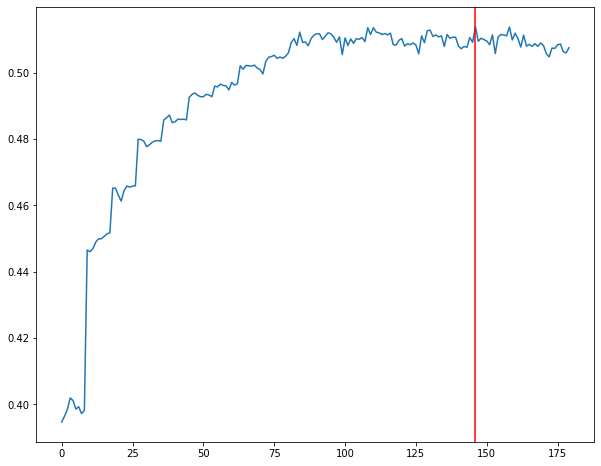

In [73]:
best_p = cv.loc[cv.rank_test_score == 1].index.values[0]
plt.figure(figsize=(10,8))
plt.plot(range(len(cv['params'])),cv['mean_test_score'])
plt.axvline(x=best_p, color='r')
plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("best parameter index",fontsize=16)

plt.show()

In [82]:
best_params = cv.loc[best_p,'params']
print(best_params)

{'max_depth': 17, 'n_estimators': 200}


## CV for feature selection

In [ ]:
%%time

feature_list = ['BlockDensity','OtherPuzAns','AvgAnswerLength','PctPerplex','PctOneWdHints','NumRepeatedAnswers_Norm', 'PctPNC','PctWP']
feature_combos = powerset(feature_list)


accs = np.zeros((5,len(feature_combos)))
precs = np.zeros((5,len(feature_combos)))
recs = np.zeros((5,len(feature_combos)))

for j, combo in enumerate(feature_combos):
    X = features[combo].to_numpy()
    y = features[['WeekdayNum']].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)
    kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
    
    clear_output(wait=True)
    display(f"testing subset {j+1} (of {len(feature_combos)})")
    
    rf = RandomForestClassifier(n_estimators = 200, max_depth=17, random_state=617,verbose=1)
    i=0
    for train_index, test_index in kfold.split(X_train, y_train):
        X_train_train, X_train_test = X_train[train_index], X_train[test_index]
        y_train_train, y_train_test = y_train[train_index], y_train[test_index]
        
        rf_clone = clone(rf)
        rf_clone.fit(X_train_train,y_train_train.ravel())
        
        y_predict = rf_clone.predict(X_train_test)
        accs[i,j] = accuracy_score(y_train_test,y_predict)
        precs[i,j] = precision_score(y_train_test,y_predict,average='weighted',zero_division=0)
        recs[i,j] = recall_score(y_train_test,y_predict,average='weighted',zero_division=0)
        i = i + 1

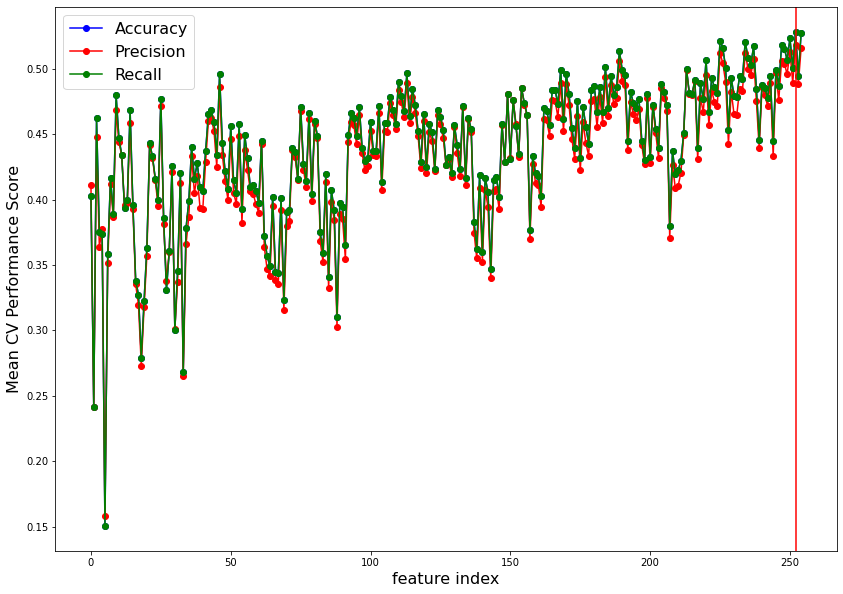

In [6]:
best_features = np.argmax(np.mean(accs, axis=0))
plt.figure(figsize=(14,10))

plt.plot(range(len(feature_combos)), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(len(feature_combos)), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(len(feature_combos)), np.mean(recs,axis=0),'g-o', label="Recall")
plt.axvline(x=best_features, color='r')
#plt.annotate("best depth",(best_k+1,37.3), fontsize=14)
plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("feature index",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [7]:
print(f"The highest accuraccy is in the model the features {feature_combos[best_features]}.")

The highest accuraccy is in the model the features ['BlockDensity', 'AvgAnswerLength', 'PctPerplex', 'PctOneWdHints', 'NumRepeatedAnswers_Norm', 'PctPNC', 'PctWP'].


## details on best model

In [14]:
# hardcoded here from CV results

est = 200
dep = 17
feat = ['BlockDensity', 
          'PctPerplex', 
          'AvgAnswerLength', 
          'PctOneWdHints', 
          'NumRepeatedAnswers_Norm', 
          'PctPNC', 
          'PctWP']

In [17]:
X = features[feat].to_numpy()
#X = features[feature_combos[best_features]].to_numpy()

y = features[['WeekdayNum']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)

rf_f = RandomForestClassifier(n_estimators = est, max_depth=dep)
rf_f.fit(X_train,y_train.ravel())

RandomForestClassifier(max_depth=17, n_estimators=200)

In [18]:
y_pred = rf_f.predict(X_test)
f_acc = accuracy_score(y_test,y_pred)
f_prec = precision_score(y_test,y_pred,average='micro')
f_rec = recall_score(y_test,y_pred,average='micro')
print(f"Overall scores:")
print(f"Accuracy:\t{np.round(f_acc*100,2)}%")
print(f"Precision:\t{np.round(f_prec*100,2)}%")
print(f"Recall:\t\t{np.round(f_rec*100,2)}%")

Overall scores:
Accuracy:	52.09%
Precision:	52.09%
Recall:		52.09%


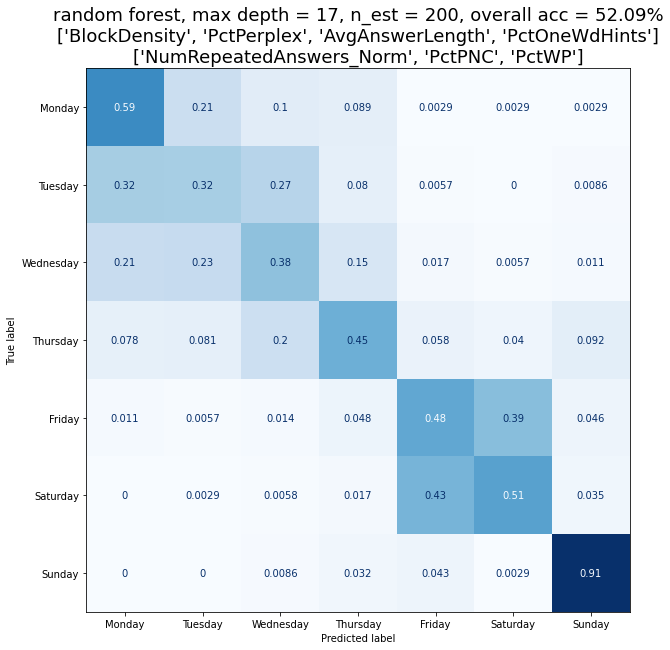

features: ['BlockDensity', 'PctPerplex', 'AvgAnswerLength', 'PctOneWdHints', 'NumRepeatedAnswers_Norm', 'PctPNC', 'PctWP']


In [20]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(rf_f, X_test, y_test, 
                      display_labels=class_labels,
                      ax=ax, 
                      normalize='true',
                      cmap=cm.get_cmap('Blues'),
                      colorbar=False)
ax.set_title(f"random forest, max depth = {dep}, n_est = {est}, overall acc = {np.round(f_acc*100,2)}%\n{feat[:4]}\n{feat[4:]}", fontsize=18)
plt.savefig("RandomForestCVfeat.png")
plt.show()
print("features:",feat)